In [207]:
import matplotlib.pyplot as plt
%matplotlib inline

In [208]:
import numpy as np
import healpy as hp

In [209]:
# download raw data

planck30 = hp.read_map('../data_files/LFI_SkyMap_030_1024_R2.01_full.fits')
planck44 = hp.read_map('../data_files/LFI_SkyMap_044_1024_R2.01_full.fits')
planck70 = hp.read_map('../data_files/LFI_SkyMap_070_1024_R2.01_full.fits')
planck100 = hp.read_map('../data_files/HFI_SkyMap_100_2048_R2.02_full.fits')
planck143 = hp.read_map('../data_files/HFI_SkyMap_143_2048_R2.02_full.fits')
planck217 = hp.read_map('../data_files/HFI_SkyMap_217_2048_R2.02_full.fits')
planck353 = hp.read_map('../data_files/HFI_SkyMap_353_2048_R2.02_full.fits')

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/Users/andrewlewis/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [210]:
# lower the resolution of the maps

planck30 = hp.ud_grade(planck30, 512)
planck44 = hp.ud_grade(planck44, 512)
planck70 = hp.ud_grade(planck70, 512)
planck100 = hp.ud_grade(planck100, 512)
planck143 = hp.ud_grade(planck143, 512)
planck217 = hp.ud_grade(planck217, 512)
planck353 = hp.ud_grade(planck353, 512)

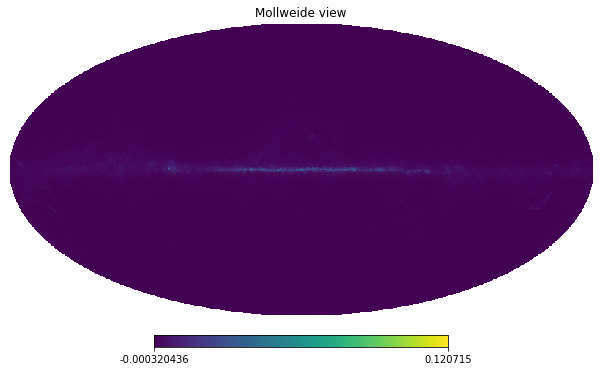

In [211]:
# example plot of raw data

hp.mollview(planck217,nest=False)

In [50]:
# implement the Lagrange method

map_array = np.array([planck30, planck44, planck70, planck100, planck143, planck217, planck353])

# define weighted map sum function

def map_sum(w):
    """Given an array of weights w,returns a weighted sum of the maps"""
    return w@map_array

In [192]:
#Generate the matrix H
def get_H(map_array):
    i = 0
    j = 0
    H = np.zeros((len(map_array), len(map_array)))
    
    for m in map_array:
        
        j = 0
        for n in map_array:
            product = m*n
            product_sum = np.sum(product)
            H[i, j] = product_sum
            j+=1
        i+=1
    return H

In [212]:
H = get_H(map_array)



In [213]:
e = np.ones(len(map_array))

In [214]:
w = (np.linalg.inv(H)@e) / (e.T@H@e)

In [196]:
#Generate the map throught weighting of different layers based on a black body spectrum
print(w)
print(np.sum(w))
print(w/np.sum(w))
opt_map = map_sum(w/np.sum(w))
print(opt_map)

[-0.00288621  0.0104061  -0.0195659   0.01101462  0.02525271 -0.00272827
 -0.00060967]
0.02088339220663807
[-0.13820596  0.4982956  -0.93691211  0.52743458  1.20922469 -0.13064282
 -0.02919399]
[-1.65588589e-04 -7.40888188e-05 -1.31758658e-05 ...  9.81450736e-05
  1.01674421e-04  9.97091627e-05]


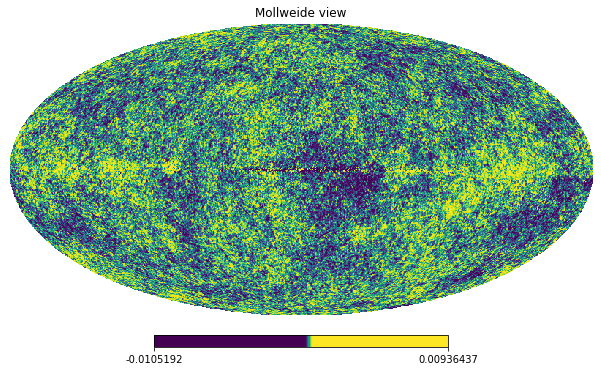

In [215]:
#Plot the optimal map
hp.mollview(opt_map, nest=False, norm='hist')

In [235]:
#Slices up the map into different regions
def sliceFixer(num_slices,array_maps):
    '''
    Slices up a given array of CMB maps into N regions as defined by num_slices, used in slicedWeightGetter
    Params:
    -------
    num_slices = the number of slices we want to divide the map into
    array_maps = the array of different CMB maps we are divinding into slices
    
    Returns:
    --------
    slicedUpMaps: A 3d array of the array_maps sliced into N different components
    
    '''
    #Creates n different slices of the cmb, and weights them correspondingly
    length_maps = len(array_maps[0])
    slicedUpMaps = []  #Initializing the array of slices
    #Start for the slices
    lowerBound = 0
    upperBound = int(length_maps/num_slices)
    
    for i in range(num_slices):   #Goes over the number of slices
        #Maps we want to add
        mapSlicesToAdd = []
        for j in array_maps:
            mapSlicesToAdd.append(j[lowerBound:upperBound])
        slicedUpMaps.append(mapSlicesToAdd)  #Add the map slices
        #Updatate the indicies to indicate a new slice
        lowerBound = upperBound
        upperBound += int(length_maps/num_slices)
    
    return slicedUpMaps
        

def slicedWeightGetter(mapSlice_array):
    '''
    returns the weight for a given slice
    Params
    ------
    mapSlice_array: a slice of a given portion of the sky over all the maps we are normalizing over
    
    Returns
    -------
    w = Array of weights for the map
    '''
    #Get H and e for the linear algebra method
    H = get_H(mapSlice_array)
    e = np.ones(len(mapSlice_array))
    
    w = (np.linalg.inv(H)@e) / (e.T@np.linalg.inv(H)@e)
    w = w/np.sum(w)  #apply the constraint all the weights must equal 1
    
    return w

def sliceCMBFixer(num_slices,map_array):
    '''
    This method will implement the slicing method to improve CMB foreground removal based on the assumption that
    the CMB acts as a blackbody
    Params
    ------
    num_slices: the number of slices we are taking of the map
    map_array: the array of maps at different frequencies of the CMB
    
    Returns
    -------
    fixed_map: the map that has had the foreground cleared using the slicing method
    
    

    '''
    #Slice up the cmb into different maps
    slicedMap = sliceFixer(num_slices, array_maps=map_array)
    
    #Apply linear algebra method (seen in class) to each map
    weights = []  #array of weights corresponding to each slice
    for i in range(num_slices):
        weights.append(slicedWeightGetter(slicedMap[i]))
    weights = np.asarray(weights)
    #Recombine the slices with the new weights
    fixed_map = []
    for i in range(num_slices):
        currentSlice = slicedMap[i]
        
        currentSlice = np.asarray(currentSlice)
        fixedPortion = weights[i]@currentSlice
        fixed_map.append(fixedPortion)
    #convert to a numpy array and flatten
    fixed_map = np.asarray(fixed_map).flatten()
    return fixed_map
    
    
        
    
    
    
    
    

3145728
[1. 1. 1. ... 1. 1. 1.]


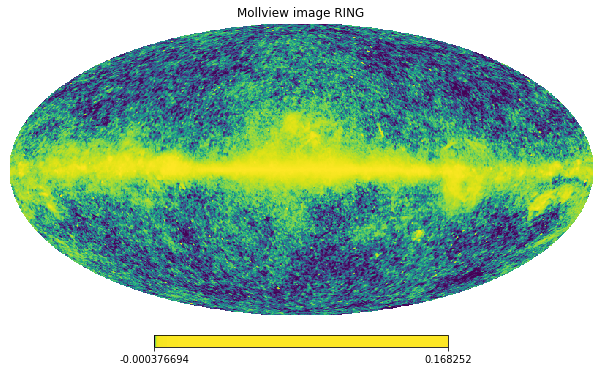

In [251]:
#Me messing around

print(hp.nside2npix(512))
shape = np.arange(hp.nside2npix(16))
shape = np.linspace(0,1,32)
shape = np.ones(3145728)
print(shape)
shape[int(3145728/3):int(3145728/12)*2] = 3
hp.mollview(newMap, title="Mollview image RING",norm= 'HIST')

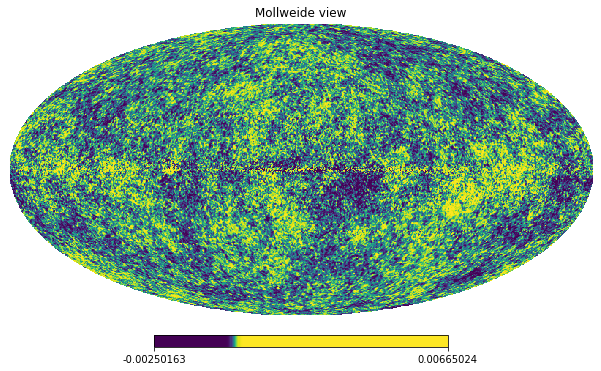

In [271]:
#Plotting the sliced map, feel free to adjust num_slices to be 6*2^n where n is any integer  
slicedMap = (sliceCMBFixer(int(786432/256),map_array))
hp.mollview(slicedMap, norm = 'Hist')
plt.savefig('48SliceFig.PNG')

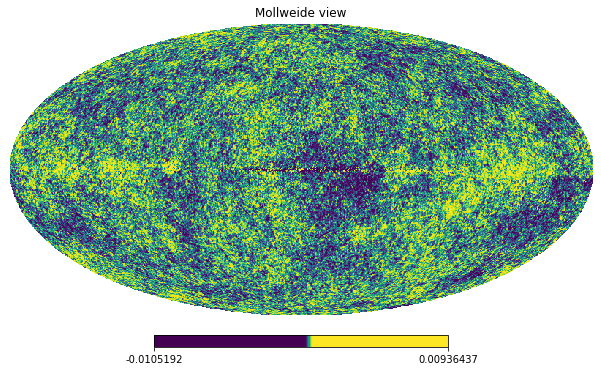

In [269]:
hp.mollview(opt_map, nest=False, norm='hist')

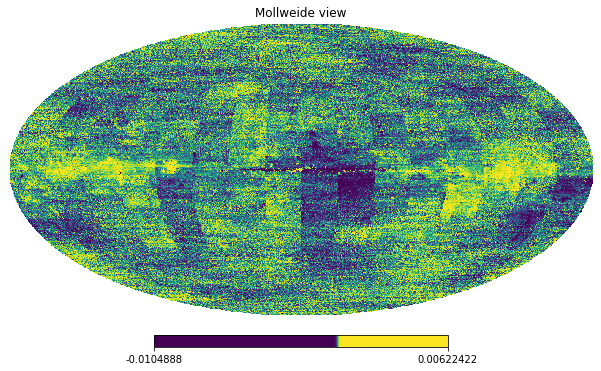

In [270]:
hp.mollview(opt_map - slicedMap, norm = 'hist')
plt.savefig('OptMinAdjusted.PNG')